In [14]:
import os 
import glob
import shutil
import imageio as iio
import ipympl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import pyplot
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerPatch
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn import preprocessing
from scipy import interpolate
import cv2
import skimage as ski
from skimage import filters
from skimage import data
from skimage import exposure
from skimage.filters import threshold_multiotsu
from skimage.data import text
from skimage import io
from PIL import Image 
from PIL import ImageFilter
import plotly.graph_objects as go
import pandas as pd
from scipy.signal import savgol_filter
import qrcode

%matplotlib widget
%matplotlib inline

### Plot dictionary 

In [15]:
title_font = {'family': 'arial', 'size': 12}
label_font = {'family': 'arial', 'size': 12}
label_tick =  10
legend_size = 10
rcParams= 'Arial'
dpi_num=300

### Importing file to acquire binary masks

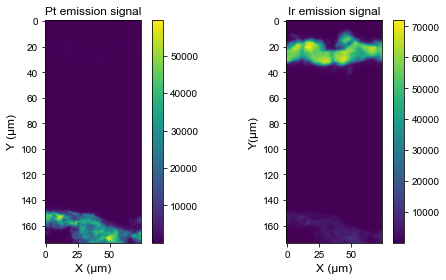

In [19]:
# Directories
day = "20230624"
sample_name="20230624020313_noXRD_XRF_XY_100ms_11700eV_017_2.2V_II_20_01_detail_hc"
element = "Pt" # "Ir", "Fe" ....
detector="02"

#Plot directory
dir_before="D:/Data1/pshell_data/"+day+"/"+sample_name+"/processed_data/FalconX/"
path_pic=dir_before+"Final_Plots_paper_"+element+"/" 

if os.path.exists(path_pic):
    shutil.rmtree(path_pic)
    os.mkdir(path_pic) 
else:
    os.mkdir(path_pic) 


# load the real processed image
uri="D:/Data1/pshell_data/"+day+"/"+sample_name+"/processed_data/FalconX/outFast_data_scan_det"+detector+"/IMAGES/Stack_outFast_SUM.tif"

im= io.imread(uri) # im[0]...im[12] --> Pt = 0, Ir = 1... Abs = 12  

gray_values_pt=im[0]
gray_values_ir=im[1]


## Plots
plt.rcParams['font.family'] = rcParams

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))

ax1=plt.subplot(121)

ax1.set_title('Pt emission signal', fontdict=title_font)
ax1.set_xlabel('X (µm)', fontdict=label_font)
ax1.set_ylabel('Y (µm)', fontdict=label_font)
ax1.tick_params(axis='both', labelsize=label_tick)
p1=ax1.imshow(np.rot90(gray_values_pt, k=2))
fig.colorbar(p1, ax=ax1,shrink=1)
# Set labels with a specific font style

ax2=plt.subplot(122)
ax2.set_title('Ir emission signal', fontdict=title_font)
ax2.set_xlabel("X (µm)", fontdict=label_font)
ax2.set_ylabel("Y(µm)", fontdict=label_font)
ax2.tick_params(axis='both', labelsize=label_tick)
p2=ax2.imshow(np.rot90(gray_values_ir, k=2))
fig.colorbar(p2, ax=ax2,shrink=1)

plt.tight_layout()

##==========================================
# Customize the file path
file_path = path_pic+'Pt and Ir slices.png'

# Save only the first subplot
plt.savefig(file_path,dpi=dpi_num)

plt.show()

### Blur filter

In [20]:
## Delete old path
path_1=dir_before+"Plot_of_stacks_"+element+"/"

if os.path.exists(path_1):
    shutil.rmtree(path_1)
    os.mkdir(path_1) 
else:
    os.mkdir(path_1) 

# convert the image to dataframe
gray_values_pt_DF=pd.DataFrame(gray_values_pt)
gray_values_ir_DF=pd.DataFrame(gray_values_ir)

# blur the image to denoise
blurred_gray_pt = ski.filters.gaussian(gray_values_pt, sigma=0.8)
blurred_gray_ir = ski.filters.gaussian(gray_values_ir, sigma=0.8)

### Thresholding sample

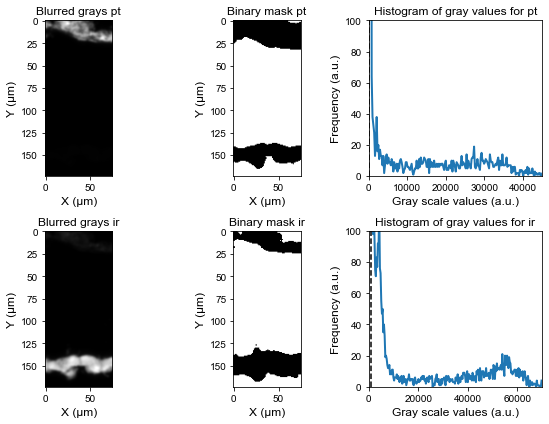

threshold for Pt = 100
threshold for Ir = 1000


In [21]:
## create a histogram of the blurred grayscale images
val_pt =100 #filters.threshold_triangle(blurred_gray_pt) # Otsu, minimum or Triangle are the favorites 
val_ir =1000 #filters.threshold_triangle(blurred_gray_ir) # Otsu, minimum or Triangle are the favorites 

hist_pt, bins_center_pt = exposure.histogram(blurred_gray_pt)
hist_ir, bins_center_ir = exposure.histogram(blurred_gray_ir)


## Plots
plt.figure(figsize=(8, 6))
ax1=plt.subplot(2,3,1)
ax1.set_title('Blurred grays pt', fontdict=title_font)
ax1.set_xlabel('X (µm)', fontdict=label_font)
ax1.set_ylabel('Y (µm)', fontdict=label_font)
ax1.tick_params(axis='both', labelsize=label_tick)
plt.imshow(blurred_gray_pt, cmap='gray')

ax2=plt.subplot(2,3,2)
ax2.set_title('Binary mask pt',fontdict=title_font)
ax2.set_xlabel('X (µm)', fontdict=label_font)
ax2.set_ylabel('Y (µm)', fontdict=label_font)
ax2.tick_params(axis='both', labelsize=label_tick)
plt.imshow(blurred_gray_pt < val_pt, cmap='gray')

ax3=plt.subplot(2,3,3)
ax3.set_title('Histogram of gray values for pt')
ax3.set_xlim(0, 45000) 
ax3.set_ylim(0, 100)
ax3.set_xlabel("Gray scale values (a.u.)", fontdict=label_font)
ax3.set_ylabel("Frequency (a.u.)", fontdict=label_font)
ax3.tick_params(axis='both', labelsize=label_tick)
plt.plot(bins_center_pt, hist_pt, lw=2)
plt.axvline(val_pt, color='k', ls='--')

ax4=plt.subplot(2,3,4)
ax4.set_title('Blurred grays ir')
ax4.set_xlabel('X (µm)', fontdict=label_font)
ax4.set_ylabel('Y (µm)', fontdict=label_font)
ax4.tick_params(axis='both', labelsize=label_tick)
plt.imshow(blurred_gray_ir, cmap='gray')

ax5=plt.subplot(2,3,5)
ax5.set_title('Binary mask ir', fontdict=title_font)
ax5.set_xlabel('X (µm)', fontdict=label_font)
ax5.set_ylabel('Y (µm)', fontdict=label_font)
ax5.tick_params(axis='both', labelsize=label_tick)
plt.imshow(blurred_gray_ir < val_ir, cmap='gray')

ax6=plt.subplot(2,3,6)
ax6.title.set_text('Histogram of gray values for ir')
ax6.set_xlim(0, 70000) 
ax6.set_ylim(0, 100)
ax6.set_xlabel("Gray scale values (a.u.)", fontdict=label_font)
ax6.set_ylabel("Frequency (a.u.)", fontdict=label_font)
ax6.tick_params(axis='both', labelsize=label_tick)
plt.plot(bins_center_ir, hist_ir, lw=2)
plt.axvline(val_ir, color='k', ls='--')

plt.tight_layout()
plt.show()

print("threshold for Pt =",val_pt)
print("threshold for Ir =",val_ir)

### Binary mask for coordinates

C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\3014511547.py:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_elements = [Rectangle((0, 0), 1, 1, color='yellow', edgecolor='black', lw=2),
C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\3014511547.py:22: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Rectangle((0, 0), 1, 1, color='purple', edgecolor='black', lw=2)]
C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\3014511547.py:34: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_elements = [Rectangle((0, 0), 1, 1, color='yellow', edgecolor='black', lw=2),
C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\3014511547.py:35: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Rectangle((0, 0), 1, 1, color='purple', edgecolor='black', lw=2)]


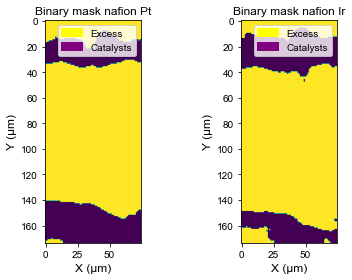

C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\3014511547.py:69: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_elements = [Rectangle((0, 0), 1, 1, color='yellow', edgecolor='black', lw=2),
C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\3014511547.py:70: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Rectangle((0, 0), 1, 1, color='purple', edgecolor='black', lw=2)]
C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\3014511547.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_elements = [Rectangle((0, 0), 1, 1, color='yellow', edgecolor='black', lw=2),
C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\3014511547.py:83: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Rectangle((0, 0), 1, 1, color='purple', edgecolor='black', lw=2)]


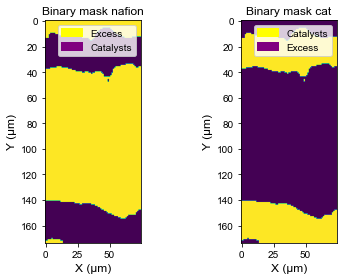

In [22]:
# Binary mask -----------------------------------------------------------------------

t_pt = val_pt
t_ir = val_ir

binary_mask_nafion_pt = blurred_gray_pt < t_pt
binary_mask_nafion_ir = blurred_gray_ir < t_ir

#Plot1-------------------------------------------------------------------------------

plt.rcParams['font.family'] = rcParams

plt.figure(figsize=(6, 4))

ax1=plt.subplot(121)
ax1.set_title('Binary mask nafion Pt', fontdict=title_font)
ax1.set_xlabel('X (µm)', fontdict=label_font)
ax1.set_ylabel('Y (µm)', fontdict=label_font)
ax1.tick_params(axis='both', labelsize=label_tick)
legend_labels = ['Excess','Catalysts']
legend_elements = [Rectangle((0, 0), 1, 1, color='yellow', edgecolor='black', lw=2),
                   Rectangle((0, 0), 1, 1, color='purple', edgecolor='black', lw=2)]
ax1.legend(legend_elements, legend_labels, loc='upper right',fontsize=legend_size)
plt.imshow(np.rot90(binary_mask_nafion_pt, k=2))

#------------------------------------------------------------------------------------

ax2=plt.subplot(122)
ax2.set_title('Binary mask nafion Ir', fontdict=title_font)
ax2.set_xlabel('X (µm)', fontdict=label_font)
ax2.set_ylabel('Y (µm)', fontdict=label_font)
ax2.tick_params(axis='both', labelsize=label_tick)
legend_labels = ['Excess','Catalysts']
legend_elements = [Rectangle((0, 0), 1, 1, color='yellow', edgecolor='black', lw=2),
                   Rectangle((0, 0), 1, 1, color='purple', edgecolor='black', lw=2)]
ax2.legend(legend_elements, legend_labels, loc='upper right',fontsize=legend_size)
plt.imshow(np.rot90(binary_mask_nafion_ir, k=2))

plt.tight_layout()
plt.show()

#Split cat layers
def split_list(a_list):
    half = len(a_list)//2
    return a_list[:half], a_list[half:]

binary_mask_nafion_pt_half_top, binary_mask_nafion_pt_half_bottom = split_list(binary_mask_nafion_pt)
binary_mask_nafion_pt_half_top_DF=pd.DataFrame(binary_mask_nafion_pt_half_top)

binary_mask_nafion_ir_half_top, binary_mask_nafion_ir_half_bottom = split_list(binary_mask_nafion_ir)
binary_mask_nafion_ir_half_bottom_DF=pd.DataFrame(binary_mask_nafion_ir_half_bottom)

#### Mixing both coordinates from different slices from the stack
binary_mask_nafion=pd.concat([binary_mask_nafion_pt_half_top_DF, binary_mask_nafion_ir_half_bottom_DF],axis=0)
binary_mask_cat=~binary_mask_nafion

#Plot2-------------------------------------------------------------------------------
    
plt.rcParams['font.family'] = rcParams

plt.figure(figsize=(6, 4))

ax3=plt.subplot(121)
ax3.set_title('Binary mask nafion', fontdict=title_font)
ax3.set_xlabel('X (µm)', fontdict=label_font)
ax3.set_ylabel('Y (µm)', fontdict=label_font)
ax3.tick_params(axis='both', labelsize=label_tick)
legend_labels = ['Excess','Catalysts']
legend_elements = [Rectangle((0, 0), 1, 1, color='yellow', edgecolor='black', lw=2),
                   Rectangle((0, 0), 1, 1, color='purple', edgecolor='black', lw=2)]
ax3.legend(legend_elements, legend_labels, loc='upper right',fontsize=legend_size)
plt.imshow(np.rot90(binary_mask_nafion, k=2))

#------------------------------------------------------------------------------------

ax4=plt.subplot(122)
ax4.set_title('Binary mask cat', fontdict=title_font)
ax4.set_xlabel('X (µm)', fontdict=label_font)
ax4.set_ylabel('Y (µm)', fontdict=label_font)
ax4.tick_params(axis='both', labelsize=label_tick)
legend_labels = ['Catalysts','Excess']
legend_elements = [Rectangle((0, 0), 1, 1, color='yellow', edgecolor='black', lw=2),
                   Rectangle((0, 0), 1, 1, color='purple', edgecolor='black', lw=2)]
ax4.legend(legend_elements, legend_labels, loc='upper right',fontsize=legend_size)
plt.imshow(np.rot90(binary_mask_cat, k=2))            

plt.tight_layout()


##==========================================
# Customize the file path
file_path = path_pic+'Cat and excess.png'
plt.savefig(file_path, dpi=dpi_num)
plt.show()

#print(binary_mask)
binary_mask_nafion_DF=pd.DataFrame(binary_mask_nafion)
binary_mask_cat_DF=pd.DataFrame(binary_mask_cat)


## Separating main parts based on the real treated image - detector 2 or detector 3

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


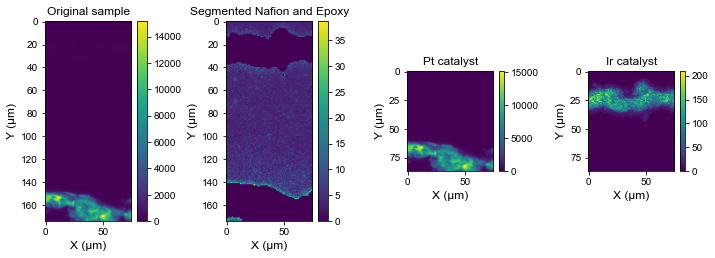

In [29]:
## Use the binary_mask to select the "interesting" part of the image (membrane and catalyst layers)

# load the real processed image

detector="02"

dir_before="D:/Data1/pshell_data/"+day+"/"+sample_name+"/processed_data/FalconX/"
uri2="D:/Data1/pshell_data/"+day+"/"+sample_name+"/processed_data/FalconX/outFast_data_scan_det"+detector+"/IMAGES/stack/Stack_outFast_SingleDet02.tif"

# convert the real image to dataframe
im = io.imread(uri2) # im[0]...im[13] --> Pt = 0, Ir = 1... Ba = 12 
real_im=im[0] # for Pt analysis

# Plots ----------------------------------------------------------------------------------------
plt.rcParams['font.family'] = rcParams

#Original sample
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 9))
ax1=plt.subplot(141)
ax1.set_title('Original sample', fontdict=title_font)
ax1.set_xlabel('X (µm)', fontdict=label_font)
ax1.set_ylabel('Y (µm)', fontdict=label_font)
ax1.tick_params(axis='both', labelsize=label_tick)
p1=plt.imshow(np.rot90(real_im, k=2))   
fig.colorbar(p1, ax=ax1, shrink=0.32)

#Nafion Layer
selection1 = real_im.copy()
selection1[~binary_mask_nafion] = 0
ax2=plt.subplot(142)
ax2.set_title('Segmented Nafion and Epoxy', fontdict=title_font)
ax2.set_xlabel('X (µm)', fontdict=label_font)
ax2.set_ylabel('Y (µm)', fontdict=label_font)
ax2.tick_params(axis='both', labelsize=label_tick)
p2=plt.imshow(np.rot90(selection1, k=2))
fig.colorbar(p2, ax=ax2, shrink=0.32)


#Catalyst Layers --> it is difficult to visualize both cat layers but they are --> .csv has gray values
selection2 = real_im.copy()
selection2[~binary_mask_cat] = 0

#Split cat layers
def split_list(a_list):
    half = len(a_list)//2
    return a_list[:half], a_list[half:]

selectionPt, selectionIr = split_list(selection2)
    
    
#First half Pt
ax3=plt.subplot(143)
ax3.set_title('Pt catalyst', fontdict=title_font)
ax3.set_xlabel('X (µm)', fontdict=label_font)
ax3.set_ylabel('Y (µm)', fontdict=label_font)
ax3.tick_params(axis='both', labelsize=label_tick)
p3=plt.imshow(np.rot90(selectionPt, k=2))
fig.colorbar(p3, ax=ax3, shrink=0.16)

#Second half Ir
selectionIr
ax4=plt.subplot(144)
ax4.set_title('Ir catalyst', fontdict=title_font)
ax4.set_xlabel('X (µm)', fontdict=label_font)
ax4.set_ylabel('Y (µm)', fontdict=label_font)
ax4.tick_params(axis='both', labelsize=label_tick)
p4=plt.imshow(np.rot90(selectionIr, k=2))
fig.colorbar(p4, ax=ax4, shrink=0.16)

plt.tight_layout()


##==========================================
# Customize the file path
file_path = path_pic+'Sample segmented_epoxy.png'
plt.savefig(file_path, dpi=300)
plt.show()


### Saving selections for real image (plot of stacks)

In [30]:
# Saving .csv files -----------------------------------------------------------------------------
selection1_DF=pd.DataFrame(selection1) # nafion
selection1_DF.to_csv(path_1+"gray_values_nafion_DF.csv")

selectionPt_DF=pd.DataFrame(selectionPt) # cat
selectionPt_DF.to_csv(path_1+"gray_values_Pt_DF.csv")

selectionIr_DF=pd.DataFrame(selectionIr) # cat
selectionIr_DF.to_csv(path_1+"gray_values_Ir_DF.csv")

gray_values_real_DF=pd.DataFrame(real_im)
gray_values_real_DF.to_csv(path_1+"gray_values_real_DF.csv")

## Borders (1d vectors for fiji) 

### Pt catalyst layer

In [31]:
## Collect superior border and last border  and then average to get X and Y coordinates of the average
dir_before="D:/Data1/pshell_data/"+day+"/"+sample_name+"/processed_data/FalconX/"

path_pt=dir_before+"Plot_of_stacks_"+element+"/Plot_of_stacks_Pt/"


if os.path.exists(path_pt):
    shutil.rmtree(path_pt)
    os.mkdir(path_pt) 
else:
    os.mkdir(path_pt) 


#define '0' matrix to be transformed in a Data frame full of coordinates of catalyst border values
border_top_Pt=[[0]*3]*len(selectionPt_DF.columns) # border_top_Pt = Border values for the Top Pt
border_top_Pt_DF=pd.DataFrame(border_top_Pt)
border_top_Pt_DF=border_top_Pt_DF.rename(columns={0:"X_border",1:"Y_border",2:"Intensity_border"}) 

#define '0' matrix to be transformed in a Data frame full of coordinates of catalyst border values
border_bottom_Pt=[[0]*3]*len(selectionPt_DF.columns) # border_top_Pt = Border values for the Top Pt
border_bottom_Pt_DF=pd.DataFrame(border_bottom_Pt)
border_bottom_Pt_DF=border_bottom_Pt_DF.rename(columns={0:"X_border",1:"Y_border",2:"Intensity_border"}) 


skip = 0 

for j in range(0,len(selection1_DF.columns)-1):
    
    a_p = selectionPt_DF.iloc[:,j]
    a=a_p.to_frame()
    a=a.rename(columns={j:"Intensity"})
    count=np.count_nonzero(a_p)
    
    if count >=10:
        a = a.dropna() #cleans Dataframe 'a_1' with NaN values  
        a =a[a['Intensity'] !=0]
        a.to_csv(path_pt+"/Plot_of_stack_Pt_{}.csv".format(j+1)) 
        
        ## User defined variable ##
    
        fine_tune = 10 # add or subtracts 'x' pixels from y coordinate -- shrinking or expanding the Nafion membrane region 
        
        #First border for Pt
        border_top_Pt_DF['Intensity_border'].values[j+1] = a['Intensity'].values[0]     
        border_top_Pt_DF['Y_border'].values[j+1] = a.first_valid_index()-fine_tune
        border_top_Pt_DF['X_border'].values[j+1] = j+1

        #Second border for Pt
        size_frame=len(a)-1
        border_bottom_Pt_DF['Intensity_border'].values[j+1] = a['Intensity'].values[size_frame]      
        border_bottom_Pt_DF['Y_border'].values[j+1] = a.index[-1]-fine_tune
        border_bottom_Pt_DF['X_border'].values[j+1] = j+1       
        
    else:
        skip=skip+1
        a = a.dropna() #cleans Dataframe 'a_1' with NaN values  
        a =a[a['Intensity'] !=0]
           
j=j+1    

#print(border_top_Pt_DF)
#print(border_bottom_Pt_DF)

# TOP --------------------------------------------------------------------------------------------
contour_first_Pt=[0]*(len(border_top_Pt_DF))*2 
contour_first_Pt_DF=pd.DataFrame(contour_first_Pt)
contour_first_Pt_DF=contour_first_Pt_DF.rename(columns={0:"Coordinates_1D"}) 

for i in range(0,len(border_top_Pt_DF)):
    contour_first_Pt_DF['Coordinates_1D'].values[i*2] = border_top_Pt_DF['X_border'].values[i]
    
for i in range(1,len(border_top_Pt_DF)+1):    
    contour_first_Pt_DF['Coordinates_1D'].values[2*i-1] = border_top_Pt_DF['Y_border'].values[i-1]

contour_first_Pt_DF = contour_first_Pt_DF.dropna() #cleans NaN values
contour_first_Pt_DF = contour_first_Pt_DF[contour_first_Pt_DF['Coordinates_1D'] != 0] #cleans 0 values

list_1c=contour_first_Pt_DF['Coordinates_1D'].tolist()

# Bottom ------------------------------------------------------------------------------------------
contour_second_Pt=[0]*(len(border_bottom_Pt_DF))*2 
contour_second_Pt_DF=pd.DataFrame(contour_second_Pt)
contour_second_Pt_DF=contour_second_Pt_DF.rename(columns={0:"Coordinates_1D"}) 

for i in range(0,len(border_bottom_Pt_DF)):
    contour_second_Pt_DF['Coordinates_1D'].values[i*2] = border_bottom_Pt_DF['Y_border'].values[i]
    
for i in range(1,len(border_bottom_Pt_DF)+1):    
    contour_second_Pt_DF['Coordinates_1D'].values[2*i-1] = border_bottom_Pt_DF['X_border'].values[i-1]

contour_second_Pt_DF = contour_second_Pt_DF.dropna() #cleans NaN values
contour_second_Pt_DF = contour_second_Pt_DF[contour_second_Pt_DF['Coordinates_1D'] != 0] #cleans 0 values    
contour_second_Pt_DF = contour_second_Pt_DF.iloc[::-1] #reverse row's order for better data acquisition

list_2c=contour_second_Pt_DF['Coordinates_1D'].tolist()

# Concatenate ------------------------------------------------------------------------------------------
bigDF_Pt=pd.concat([contour_first_Pt_DF, contour_second_Pt_DF])
biglist_Pt=bigDF_Pt['Coordinates_1D'].tolist()
print(biglist_Pt)

## feed the linear regressor tool with X and Y coordinates to get the line 
#data = pd.read_csv(linear_dir2)  # load data set
#X = data.iloc[1:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
#Y = data.iloc[1:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X, Y)  # perform linear regression'
#Y_pred = linear_regressor.predict(X)  # make predictions

#plt.scatter(X, Y)
#plt.plot(X, Y_pred, color='red')
#plt.show()


# ROTATE: Final step
#rotate_img= img.rotate(45)
 
#rotate_img.show() 

[1, -10, 2, -10, 3, -10, 4, -10, 5, -10, 6, -10, 7, -10, 8, -10, 9, -10, 10, -10, 11, -10, 12, -10, 13, -10, 14, -10, 15, -10, 16, -10, 17, -10, 18, -10, 19, -10, 20, -10, 21, -10, 22, -10, 23, -10, 24, -10, 25, -10, 26, -10, 27, -10, 28, -10, 29, -10, 30, -10, 31, -10, 32, -10, 33, -10, 34, -10, 35, -10, 36, -10, 37, -10, 38, -10, 39, -10, 40, -10, 41, -10, 42, -10, 43, -10, 44, -10, 45, -10, 46, -10, 47, -10, 48, -10, 49, -10, 50, -10, 51, -10, 52, -10, 53, -10, 54, -10, 55, -10, 56, -10, 57, -10, 58, -10, 59, -10, 60, -10, 61, -10, 62, -8, 63, -8, 64, -7, 65, -7, 66, -7, 67, -7, 68, -7, 69, -7, 70, -6, 71, -7, 72, -7, 73, -7, 74, -8, 74, 22, 73, 22, 72, 22, 71, 22, 70, 22, 69, 22, 68, 22, 67, 22, 66, 22, 65, 22, 64, 22, 63, 21, 62, 21, 61, 21, 60, 21, 59, 21, 58, 21, 57, 21, 56, 21, 55, 21, 54, 21, 53, 21, 52, 20, 51, 20, 50, 20, 49, 20, 48, 19, 47, 19, 46, 20, 45, 20, 44, 20, 43, 20, 42, 20, 41, 20, 40, 20, 39, 19, 38, 19, 37, 19, 36, 18, 35, 18, 34, 17, 33, 17, 32, 16, 31, 15, 30,

### Ir catalyst layer

In [32]:
## Collect superior border and last border  and then average to get X and Y coordinates of the average
dir_before="D:/Data1/pshell_data/"+day+"/"+sample_name+"/processed_data/FalconX/"
path_2=dir_before+"Plot_of_stacks/"

path_Ir=dir_before+"Plot_of_stacks_"+element+"/Plot_of_stacks_Ir/"

if os.path.exists(path_Ir):
    shutil.rmtree(path_Ir)
    os.mkdir(path_Ir) 
else:
    os.mkdir(path_Ir) 
    

#define '0' matrix to be transformed in a Data frame full of coordinates of catalyst border values
border_top_Ir=[[0]*3]*len(selectionIr_DF.columns) # border_top_Ir = Border values for the Top Ir
border_top_Ir_DF=pd.DataFrame(border_top_Ir)
border_top_Ir_DF=border_top_Ir_DF.rename(columns={0:"X_border",1:"Y_border",2:"Intensity_border"}) 

#define '0' matrix to be transformed in a Data frame full of coordinates of catalyst border values
border_bottom_Ir=[[0]*3]*len(selectionIr_DF.columns) # border_top_Ir = Border values for the Top Ir
border_bottom_Ir_DF=pd.DataFrame(border_bottom_Ir)
border_bottom_Ir_DF=border_bottom_Ir_DF.rename(columns={0:"X_border",1:"Y_border",2:"Intensity_border"}) 


skip = 0 

for j in range(0,len(selectionIr_DF.columns)-1):
    
    a_p = selectionIr_DF.iloc[:,j]
    a=a_p.to_frame()
    a=a.rename(columns={j:"Intensity"})
    count=np.count_nonzero(a_p)
    
    if count >=10:
        a = a.dropna() #cleans Dataframe 'a_1' with NaN values  
        a =a[a['Intensity'] !=0]
        a.to_csv(path_Ir+"/Plot_of_stack_ir_{}.csv".format(j+1)) 
        
        ## User defined variable ##
    
        fine_tune = 10 # add or subtracts 'x' pixels from y coordinate -- shrinking or expanding the Nafion membrane region 
        
        #First border for Ir
        border_top_Ir_DF['Intensity_border'].values[j+1] = a['Intensity'].values[0]     
        border_top_Ir_DF['Y_border'].values[j+1] = a.first_valid_index()+len(selectionPt)-fine_tune
        border_top_Ir_DF['X_border'].values[j+1] = j+1

        #Second border for Ir
        size_frame=len(a)-1
        border_bottom_Ir_DF['Intensity_border'].values[j+1] = a['Intensity'].values[size_frame]      
        border_bottom_Ir_DF['Y_border'].values[j+1] = a.index[-1]+len(selectionPt)-fine_tune 
        border_bottom_Ir_DF['X_border'].values[j+1] = j+1       
        
    else:
        skip=skip+1
        a = a.dropna() #cleans Dataframe 'a_1' with NaN values  
        a =a[a['Intensity'] !=0]
           
j=j+1    

#print(border_top_Ir_DF)
#print(border_bottom_Ir_DF)

# TOP --------------------------------------------------------------------------------------------
contour_first_Ir=[0]*(len(border_top_Ir_DF))*2 
contour_first_Ir_DF=pd.DataFrame(contour_first_Ir)
contour_first_Ir_DF=contour_first_Ir_DF.rename(columns={0:"Coordinates_1D"}) 

for i in range(0,len(border_top_Ir_DF)):
    contour_first_Ir_DF['Coordinates_1D'].values[i*2] = border_top_Ir_DF['X_border'].values[i]
    
for i in range(1,len(border_top_Ir_DF)+1):    
    contour_first_Ir_DF['Coordinates_1D'].values[2*i-1] = border_top_Ir_DF['Y_border'].values[i-1]

contour_first_Ir_DF = contour_first_Ir_DF.dropna() #cleans NaN values
contour_first_Ir_DF = contour_first_Ir_DF[contour_first_Ir_DF['Coordinates_1D'] != 0] #cleans 0 values

list_1c=contour_first_Ir_DF['Coordinates_1D'].tolist()

# Bottom ------------------------------------------------------------------------------------------
contour_second_Ir=[0]*(len(border_bottom_Ir_DF))*2 
contour_second_Ir_DF=pd.DataFrame(contour_second_Ir)
contour_second_Ir_DF=contour_second_Ir_DF.rename(columns={0:"Coordinates_1D"}) 

for i in range(0,len(border_bottom_Ir_DF)):
    contour_second_Ir_DF['Coordinates_1D'].values[i*2] = border_bottom_Ir_DF['Y_border'].values[i]
    
for i in range(1,len(border_bottom_Ir_DF)+1):    
    contour_second_Ir_DF['Coordinates_1D'].values[2*i-1] = border_bottom_Ir_DF['X_border'].values[i-1]

contour_second_Ir_DF = contour_second_Ir_DF.dropna() #cleans NaN values
contour_second_Ir_DF = contour_second_Ir_DF[contour_second_Ir_DF['Coordinates_1D'] != 0] #cleans 0 values    
contour_second_Ir_DF = contour_second_Ir_DF.iloc[::-1] #reverse row's order for better data acquisition


list_2c=contour_second_Ir_DF['Coordinates_1D'].tolist()

# Concatenate ------------------------------------------------------------------------------------------
bigDF_Ir=pd.concat([contour_first_Ir_DF, contour_second_Ir_DF])
biglist_Ir=bigDF_Ir['Coordinates_1D'].tolist()
print(biglist_Ir)

[1, 128, 2, 128, 3, 127, 4, 127, 5, 128, 6, 129, 7, 130, 8, 130, 9, 130, 10, 130, 11, 130, 12, 130, 13, 129, 14, 129, 15, 129, 16, 129, 17, 128, 18, 128, 19, 128, 20, 128, 21, 127, 22, 126, 23, 123, 24, 121, 25, 120, 26, 116, 27, 120, 28, 120, 29, 120, 30, 122, 31, 123, 32, 124, 33, 124, 34, 124, 35, 124, 36, 124, 37, 123, 38, 123, 39, 122, 40, 123, 41, 123, 42, 124, 43, 124, 44, 124, 45, 123, 46, 123, 47, 124, 48, 124, 49, 124, 50, 124, 51, 124, 52, 125, 53, 125, 54, 125, 55, 126, 56, 126, 57, 126, 58, 127, 59, 127, 60, 127, 61, 127, 62, 127, 63, 128, 64, 128, 65, 128, 66, 128, 67, 127, 68, 127, 69, 127, 70, 127, 71, 127, 72, 126, 73, 126, 74, 126, 74, 149, 73, 149, 72, 152, 71, 153, 70, 153, 69, 153, 68, 153, 67, 152, 66, 152, 65, 152, 64, 151, 63, 151, 62, 151, 61, 151, 60, 152, 59, 152, 58, 152, 57, 152, 56, 152, 55, 152, 54, 152, 53, 152, 52, 151, 51, 151, 50, 151, 49, 151, 48, 150, 47, 150, 46, 149, 45, 149, 44, 149, 43, 149, 42, 149, 41, 148, 40, 147, 39, 147, 38, 148, 37, 149, 

### Nafion membrane layer

In [33]:
## Collect superior border and last border  and then average to get X and Y coordinates of the average
dir_before="D:/Data1/pshell_data/"+day+"/"+sample_name+"/processed_data/FalconX/"
path_3=dir_before+"Plot_of_stacks/"

path_nafion=dir_before+"Plot_of_stacks_"+element+"/Plot_of_stacks_Nafion/"
if os.path.exists(path_nafion):
    shutil.rmtree(path_nafion)
    os.mkdir(path_nafion) 
else:
    os.mkdir(path_nafion) 

    
#define '0' matrix to be transformed in a Data frame full of coordinates of catalyst border values
border_top_nafion=[[0]*3]*len(selection1_DF.columns) # border_top_nafion = Border values for the Top Ir
border_top_nafion_DF=pd.DataFrame(border_top_nafion)
border_top_nafion_DF=border_top_nafion_DF.rename(columns={0:"X_border",1:"Y_border",2:"Intensity_border"}) 

#define '0' matrix to be transformed in a Data frame full of coordinates of catalyst border values
border_bottom_nafion=[[0]*3]*len(selection1_DF.columns) # border_bottom_nafion = Border values for the bottom Ir
border_bottom_nafion_DF=pd.DataFrame(border_bottom_nafion)
border_bottom_nafion_DF=border_bottom_nafion_DF.rename(columns={0:"X_border",1:"Y_border",2:"Intensity_border"}) 

# generate dataframe only for membrane layer
nafion_membrane=[[0]*len(selection1_DF.columns)]*len(selection1_DF)
nafion_membrane_DF=pd.DataFrame(nafion_membrane) 

skip = 0 

for j in range(0,len(selection1_DF.columns)-1):
    a_p = selection1_DF.iloc[:,j]
    a=a_p.to_frame()
    a=a.rename(columns={j:"Intensity"})
    count=np.count_nonzero(a_p)
    
    # First index where values is c
    idx = a.index[a['Intensity'].eq(0)].min()
    idx2 = a.index[a['Intensity'].eq(0)].max()
     
    a.loc[a.index < idx]=0 # zero before top Pt border
    a.loc[a.index > idx2]=0 # zero after bottom Ir border
    
    nafion_membrane_DF[j]=a
    
    if count >=10:
        
        a = a[idx:idx2]# Drop first borders
        a = a.dropna() #cleans Dataframe 'a_1' with NaN values  
        a =a[a['Intensity'] !=0]
        a.to_csv(path_nafion+"/Plot_of_stack_nafion_{}.csv".format(j+1)) 
        
        ## User defined variable ##
    
        fine_tune = 10 # add or subtracts 'x' pixels from y coordinate -- shrinking or expanding the Nafion membrane region 
        
        #First border for Ir
        border_top_nafion_DF['Intensity_border'].values[j+1] = a['Intensity'].values[0]     
        border_top_nafion_DF['Y_border'].values[j+1] = a.first_valid_index()-fine_tune
        border_top_nafion_DF['X_border'].values[j+1] = j+1

        #Second border for Ir
        size_frame=len(a)-1
        border_bottom_nafion_DF['Intensity_border'].values[j+1] = a['Intensity'].values[size_frame]      
        border_bottom_nafion_DF['Y_border'].values[j+1] = a.index[-1]-fine_tune
        border_bottom_nafion_DF['X_border'].values[j+1] = j+1       
        
    else:
        skip=skip+1
        a = a.dropna() #cleans Dataframe 'a_1' with NaN values  
        a =a[a['Intensity'] !=0]
           
j=j+1    

#print(border_top_nafion_DF)
#print(border_bottom_nafion_DF)
#print(nafion_membrane_DF)

# TOP --------------------------------------------------------------------------------------------
contour_first_nafion=[0]*(len(border_top_nafion_DF))*2 
contour_first_nafion_DF=pd.DataFrame(contour_first_nafion)
contour_first_nafion_DF=contour_first_nafion_DF.rename(columns={0:"Coordinates_1D"}) 

for i in range(0,len(border_top_nafion_DF)):
    contour_first_nafion_DF['Coordinates_1D'].values[i*2] = border_top_nafion_DF['X_border'].values[i]
    
for i in range(1,len(border_top_nafion_DF)+1):    
    contour_first_nafion_DF['Coordinates_1D'].values[2*i-1] = border_top_nafion_DF['Y_border'].values[i-1]

contour_first_nafion_DF = contour_first_nafion_DF.dropna() #cleans NaN values
contour_first_nafion_DF = contour_first_nafion_DF[contour_first_nafion_DF['Coordinates_1D'] != 0] #cleans 0 values

list_1c=contour_first_nafion_DF['Coordinates_1D'].tolist()

# Bottom ------------------------------------------------------------------------------------------
contour_second_nafion=[0]*(len(border_bottom_nafion_DF))*2 
contour_second_nafion_DF=pd.DataFrame(contour_second_Ir)
contour_second_nafion_DF=contour_second_nafion_DF.rename(columns={0:"Coordinates_1D"}) 

for i in range(0,len(border_bottom_nafion_DF)):
    contour_second_nafion_DF['Coordinates_1D'].values[i*2] = border_bottom_nafion_DF['Y_border'].values[i]
    
for i in range(1,len(border_bottom_nafion_DF)+1):    
    contour_second_nafion_DF['Coordinates_1D'].values[2*i-1] = border_bottom_nafion_DF['X_border'].values[i-1]

contour_second_nafion_DF = contour_second_nafion_DF.dropna() #cleans NaN values
contour_second_nafion_DF = contour_second_nafion_DF[contour_second_nafion_DF['Coordinates_1D'] != 0] #cleans 0 values    
contour_second_nafion_DF = contour_second_nafion_DF.iloc[::-1] #reverse row's order for better data acquisition

list_2c=contour_second_nafion_DF['Coordinates_1D'].tolist()

# Concatenate ------------------------------------------------------------------------------------------
bigDF_nafion=pd.concat([contour_first_nafion_DF, contour_second_nafion_DF])
biglist_nafion=bigDF_nafion['Coordinates_1D'].tolist()
print(biglist_nafion) 

[1, 16, 2, 16, 3, 15, 4, 14, 5, 12, 6, 12, 7, 12, 8, 12, 9, 12, 10, 12, 11, 11, 12, 10, 13, 9, 14, 9, 15, 9, 16, 9, 17, 10, 18, 10, 19, 11, 20, 11, 21, 11, 22, 12, 23, 12, 24, 13, 25, 13, 26, 13, 27, 14, 28, 15, 29, 15, 30, 16, 31, 16, 32, 17, 33, 18, 34, 18, 35, 19, 36, 19, 37, 20, 38, 20, 39, 20, 40, 21, 41, 21, 42, 21, 43, 21, 44, 21, 45, 21, 46, 21, 47, 20, 48, 20, 49, 21, 50, 21, 51, 21, 52, 21, 53, 22, 54, 22, 55, 22, 56, 22, 57, 22, 58, 22, 59, 22, 60, 22, 61, 22, 62, 22, 63, 22, 64, 23, 65, 23, 66, 23, 67, 23, 68, 23, 69, 23, 70, 23, 71, 23, 72, 23, 73, 23, 74, 23, 74, 125, 73, 125, 72, 125, 71, 126, 70, 126, 69, 126, 68, 126, 67, 126, 66, 127, 65, 127, 64, 127, 63, 127, 62, 126, 61, 126, 60, 126, 59, 126, 58, 126, 57, 125, 56, 125, 55, 125, 54, 124, 53, 124, 52, 124, 51, 123, 50, 123, 49, 123, 48, 123, 47, 123, 46, 122, 45, 122, 44, 123, 43, 123, 42, 123, 41, 122, 40, 122, 39, 121, 38, 122, 37, 122, 36, 123, 35, 123, 34, 123, 33, 123, 32, 123, 31, 122, 30, 121, 29, 119, 28, 11

## After isolating membrane and both catalysts layers -> Fine Tune = - 10 pixels each side

<Figure size 432x288 with 0 Axes>

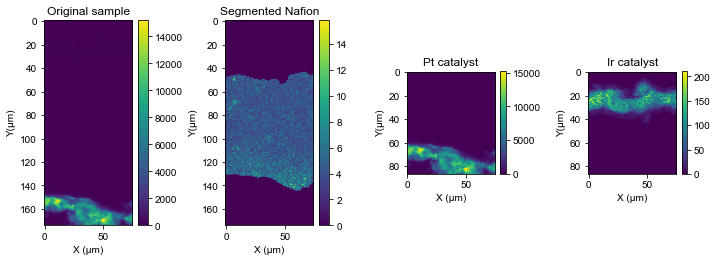

In [42]:
# Plots ----------------------------------------------------------------------------------------
plt.rcParams['font.family'] = rcParams
fig = plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 4))
ax1=plt.subplot(141)
ax1.title.set_text('Original sample')
ax1.set_xlabel("X (µm)")
ax1.set_ylabel("Y(µm)")
ax1.tick_params(axis='both', labelsize=label_tick)
p1=plt.imshow(np.rot90(real_im, k=2))   
fig.colorbar(p1, ax=ax1, shrink=0.92)


# generates dataframe only for membrane layer and remove some pixels due to the high intensity
nafion_membrane1=[[0]*len(nafion_membrane_DF.columns)]*len(nafion_membrane_DF)
nafion_membrane_DF1=pd.DataFrame(nafion_membrane1) 

for j in range(0,len(nafion_membrane_DF.columns)-1):
    a_p1 = nafion_membrane_DF.iloc[:,j]
    a1=a_p1.to_frame()
    a1=a1.rename(columns={j:"Intensity"})
    count=np.count_nonzero(a_p1)
    
    # First index where values is c
    Fine_tune_FIN=10
    idx1 = a1.index[a1['Intensity']!=0].min()+Fine_tune_FIN
    idx3 = a1.index[a1['Intensity']!=0].max()-Fine_tune_FIN
    
    a1.loc[a1.index < idx1]=0 # zero before top Pt border
    a1.loc[a1.index > idx3]=0 # zero after bottom Ir border
    
    nafion_membrane_DF1[j]=a1
j=j+1


#Nafion Layer
ax2=plt.subplot(142)
ax2.title.set_text('Segmented Nafion')
ax2.set_xlabel("X (µm)")
ax2.set_ylabel("Y(µm)")
ax2.tick_params(axis='both', labelsize=label_tick)
p2=plt.imshow(np.rot90(nafion_membrane_DF1, k=2))
fig.colorbar(p2, ax=ax2, shrink=0.92)

#First half Pt
ax3=plt.subplot(143)
ax3.title.set_text('Pt catalyst')
ax3.set_xlabel("X (µm)")
ax3.set_ylabel("Y(µm)")
ax3.tick_params(axis='both', labelsize=label_tick)
p3=plt.imshow(np.rot90(selectionPt, k=2))
fig.colorbar(p3, ax=ax3, shrink=0.46)

#Second half Ir
selectionIr
ax4=plt.subplot(144)
ax4.title.set_text('Ir catalyst')
ax4.set_xlabel("X (µm)")
ax4.set_ylabel("Y(µm)")
ax4.tick_params(axis='both', labelsize=label_tick)
p4=plt.imshow(np.rot90(selectionIr, k=2))
fig.colorbar(p4, ax=ax4, shrink=0.46)

plt.tight_layout()

#==========================================
# Customize the file path
file_path = path_pic+'Sample segmented.png'
plt.savefig(file_path,dpi=dpi_num)
plt.show()

### Filter for Nafion membrane (in case of dust)

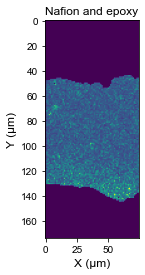

In [43]:
#Nafion Layer
binary_mask2_nafion = nafion_membrane_DF1 < 15

#binary_mask2_nafion=~binary_mask2_nafion
nafion_membrane_DF1[~binary_mask2_nafion] = 0 
ax1=plt.subplot(111)
ax1.set_title('Nafion and epoxy', fontdict=title_font)
ax1.set_xlabel('X (µm)', fontdict=label_font)
ax1.set_ylabel('Y (µm)', fontdict=label_font)
plt.imshow(np.rot90(nafion_membrane_DF1, k=2))

nafion_membrane_DF_abs=nafion_membrane_DF1.copy



### Real Image histogram (Stack_outFast_SUM)

(0.0, 150.0)

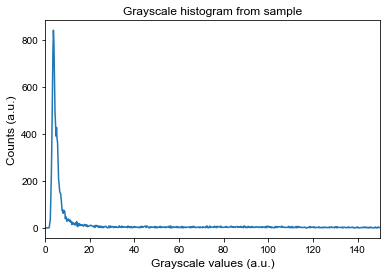

In [44]:
histogram, bin_edges = np.histogram(real_im,bins=65536) # 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536

fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)
plt.title("Grayscale histogram from sample", fontdict=title_font)
plt.xlabel("Grayscale values (a.u.)", fontdict=label_font)
plt.ylabel("Counts (a.u.)", fontdict=label_font)

plt.xlim(0, 150)

### Nafion histogram (nafion_membrane_DF1)

C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\1495445717.py:44: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_elements = [Rectangle((0, 0), 1, 1, color='orange', edgecolor='black', lw=2),
C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\1495445717.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Rectangle((0, 0), 1, 1, color='blue', edgecolor='black', lw=2)]


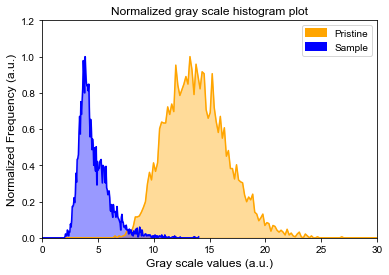

In [45]:
dir_histogram="D:/ra5994/OneDrive/Área de Trabalho/histograms/Histograms samples/paper2/"+sample_name+element+".csv"
    
dir_mem="D:/ra5994/OneDrive/Área de Trabalho/histograms/20230622113436_noXRD_XRF_XY_100ms_11700eV_008_Pristine_02_detail1_hc_Pt.csv"
membrane_pris=pd.read_csv(dir_mem)


# Gets histogram from uploaded pristine sample 
bins_mem=membrane_pris.iloc[:,0]
counts=membrane_pris.iloc[:,1]
counts_norm=counts/max(counts) # Normalization by height 


# Gets histogram of nafion membrane from sample and generates a .CSV file
nafion_membrane_DF_hist=nafion_membrane_DF1
histogram_naf, bin_edges_naf = np.histogram(nafion_membrane_DF_hist,bins=256) # 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536
histogram_naf[0]=0

histogram_naf_norm=histogram_naf/histogram_naf.max() # Normalization by height 

histogram_naf_DF=pd.DataFrame(histogram_naf)
bin_edges_naf_DF=pd.DataFrame(bin_edges_naf)

histogram_sample= pd.concat([bin_edges_naf_DF,histogram_naf_DF],axis=1)
histogram_sample[np.isnan(histogram_sample)] = 0
histogram_sample.to_csv(dir_histogram)

# Plot of histograms for comparison
plt.rcParams['font.family'] = rcParams
fig, ax = plt.subplots()
lines_mem = plt.plot(bins_mem, counts_norm, color="orange")
plt.fill_between(bins_mem, counts_norm,color="orange", alpha=0.4)

lines_sample = plt.plot(bin_edges_naf[0:-1], histogram_naf_norm, color='blue')
plt.fill_between(bin_edges_naf[0:-1], histogram_naf_norm,color='blue', alpha=0.4)

plt.title("Normalized gray scale histogram plot", fontdict=title_font)
plt.xlabel("Gray scale values (a.u.)", fontdict=label_font)
plt.ylabel("Normalized Frequency (a.u.)", fontdict=label_font)
plt.xticks(fontsize=label_tick)
plt.yticks(fontsize=label_tick)
plt.xlim(0, 30)
plt.ylim(0, 1.2) # change according to analysis
legend_labels = ['Pristine','Sample']
legend_elements = [Rectangle((0, 0), 1, 1, color='orange', edgecolor='black', lw=2),
                   Rectangle((0, 0), 1, 1, color='blue', edgecolor='black', lw=2)]
plt.legend(legend_elements, legend_labels, loc='upper right',fontsize=legend_size)

# Customize the file path
file_path = path_pic+'Normalized gray scale histogram plot_'+element+'.png'

# Save only the first subplot
fig.savefig(file_path,dpi=dpi_num)
plt.subplots_adjust()
plt.show()



### 3D plot

In [47]:
# Original data
nafion_membrane_DF3D=nafion_membrane_DF1

fig = go.Figure(data=[go.Surface(z=np.rot90(nafion_membrane_DF3D.values, k=2), showscale=False)])
fig.update_layout(
    title='3D plot for intensity values',
    title_font=dict(size=12, family='Arial', color='black'),
    autosize=False,
    width=500, height=500,
    scene=dict(
         xaxis=dict(title='X', titlefont=dict(size=10, family='Arial'), tickfont=dict(size=10, family='Arial'), tickmode='auto', tick0=-5, autorange='reversed'),
        yaxis=dict(title='Y', titlefont=dict(size=10, family='Arial'), tickfont=dict(size=10, family='Arial'), tickmode='auto', tick0=-5),
        zaxis=dict(title='Intensity values (a.u.)', titlefont=dict(size=10, family='Arial'), tickfont=dict(size=10, family='Arial'), tickmode='auto', tick0=-2),
        camera=dict(
            eye=dict(x=1.75, y=1.75, z=1.75)  # Set the initial zoom size
        )
    )
    
)

fig.show()



### 3D plot matplot lib 

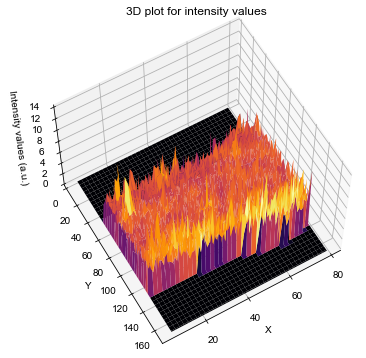

In [53]:
# Assuming nafion_membrane_DF3D.values is your matrix data
data_3d = np.rot90(nafion_membrane_DF3D.values, k=2)

# Define the range for the Y-axis
start_y_3d = 0
end_y_3d = 170

# Crop the data to the specified range along the Y-axis
cropped_data_3d = data_3d[start_y_3d:end_y_3d, :]

# Create grid for x and y coordinates
x = np.arange(cropped_data_3d.shape[1], 0, -1) 
y = np.arange(start_y_3d, end_y_3d)  # Adjusted y-coordinates to match the cropped range
x, y = np.meshgrid(x, y)

# Create Matplotlib surface plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, cropped_data_3d, cmap='inferno')

# Set plot title and labels
ax.set_title('3D plot for intensity values', fontsize=12)
ax.set_xlabel('X', fontsize=10)
ax.set_ylabel('Y', fontsize=10)
ax.set_zlabel('Intensity values (a.u.)', fontsize=10)

# Set tick parameters
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='z', labelsize=10)
tick_positions = np.arange(0, cropped_data_3d.shape[1]+5, 20)  #Set tick positions
tick_labels = np.arange(cropped_data_3d.shape[1]+5, 0, -20)  #Set tick labels in reverse order
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

#Y axis
start_value_3d= 0
end_value_3d= 170
# Set Y-axis range
ax.set_ylim([start_value_3d, end_value_3d])  # Set the desired range  
# Set camera view
ax.view_init(elev=60, azim=60)  # Adjust elevation and azimuth angles as needed

# Show the plot
plt.show()

### Multi-Otsu's -- to create 3 regions  

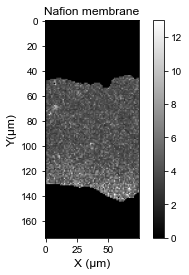

In [54]:
# Transform nafion_membrane_DF back to array
out_arr = nafion_membrane_DF1.to_numpy()

# Applying multi-Otsu threshold for the default value, generating
# three classes.
images=out_arr
thresholds = threshold_multiotsu(images)

# Using the threshold values, we generate the three regions.
regions = np.digitize(images, bins=thresholds)

plt.rcParams['font.family'] = rcParams
fig, ax = plt.subplots(figsize=(5, 4))

# Plotting the original image.
p0=ax.imshow(np.rot90(images, k=2), cmap='gray')
ax.set_title('Nafion membrane', fontdict=title_font)
ax.set_xlabel("X (µm)", fontdict=label_font)
ax.set_ylabel("Y(µm)", fontdict=label_font)
ax.tick_params(axis='both', labelsize=label_tick)

# color bar parameters
color_bar = fig.colorbar(p0, ax=ax)
custom_min_value = 0
custom_max_value = 13
p0.set_clim(vmin=custom_min_value, vmax=custom_max_value)


# Customize the file path
file_path = path_pic+'Nafion membrane_'+element+'.png'

# Save only the first subplot
p0.get_figure().savefig(file_path,dpi=dpi_num)

plt.subplots_adjust()
plt.show()


C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\202728000.py:26: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



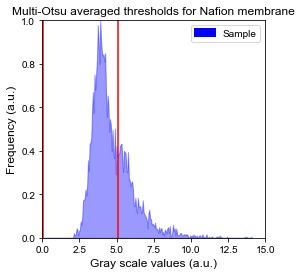

In [55]:
# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.

# Create a subplot and plot the histogram
n, bins, patches = ax.hist(images.ravel(), bins=256, color='blue', alpha=0.7)

# Normalizing excluding counts for points equal to zero 
n_without_zero=n[1:]
nonzero_bins = bins[2:]
count_values = n_without_zero / np.max(n_without_zero)

plt.rcParams['font.family'] = rcParams

fig, ax = plt.subplots(figsize=(4, 4))
#lines_mem = plt.plot(nonzero_bins, count_values, color="blue",alpha=0.8)
plt.fill_between(nonzero_bins, count_values,color="blue", alpha=0.4)
#plt.fill_between(normalized_values, nonzero_values,color="orange", alpha=0.4)

ax.set_title('Multi-Otsu averaged thresholds for Nafion membrane', fontdict=title_font)
ax.set_xlabel("Gray scale values (a.u.)", fontdict=label_font)
ax.set_ylabel("Frequency (a.u.)", fontdict=label_font)
ax.set_xlim(0, 15) 
ax.set_ylim(0, 1)
ax.tick_params(axis='both', labelsize=label_tick)
legend_labels = ['Sample']
legend_elements = [Rectangle((0, 0), 1, 1, color='blue', edgecolor='black', lw=2)]
ax.legend(legend_elements, legend_labels, loc='upper right',fontsize=legend_size)
#ax.plot(nonzero_bins, nonzero_values, color='red', marker='o', linestyle='-', linewidth=2) 

for thresh in thresholds:
    ax.axvline(thresh, color='r')

# Customize the file path
file_path = path_pic+'Multi-Otsu_'+element+'.png'

# Save only the first subplot
fig.savefig(file_path,dpi=dpi_num)
plt.subplots_adjust()
plt.show()    




C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\62343204.py:12: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\62343204.py:13: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



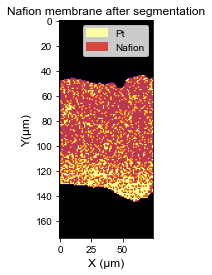

In [57]:
# Plotting the Multi Otsu result.

plt.rcParams['font.family'] = rcParams
fig, ax = plt.subplots(figsize=(5, 4))

p2=ax.imshow(np.rot90(regions, k=2), cmap='inferno')
ax.set_title('Nafion membrane after segmentation', fontdict=title_font)
ax.set_xlabel("X (µm)", fontdict=label_font)
ax.set_ylabel("Y(µm)", fontdict=label_font)
ax.tick_params(axis='both', labelsize=label_tick)
legend_labels = ['Pt', 'Nafion']
legend_elements = [Rectangle((0, 0), 1, 1, color='#FCFFA4', edgecolor='black', lw=2),
                   Rectangle((0, 0), 1, 1, color='#D44842', edgecolor='black', lw=2)]
ax.legend(legend_elements, legend_labels, loc='upper right')
#fig.colorbar(p2, ax=ax)

# Customize the file path
file_path = path_pic+'Nafion_segmentation_'+element+'.png'

# Save only the first subplot
p2.get_figure().savefig(file_path,dpi=dpi_num)

plt.subplots_adjust()
plt.show()

C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\487324120.py:12: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



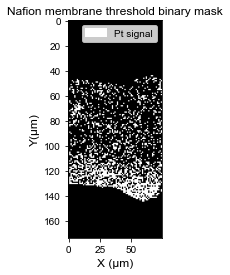

Threshold 1 =  0.08241620846092701
Threshold 2 =  5.082332855090499


In [58]:
# Plotting the Multi Otsu averaged threshold.
plt.rcParams['font.family'] = rcParams
fig, ax = plt.subplots(figsize=(5, 4))

binary_mask = nafion_membrane_DF1 < thresholds[1] # Multi-Otsu # x_min  
p3=ax.imshow(np.rot90(binary_mask, k=2), cmap='binary')
ax.set_title('Nafion membrane threshold binary mask', fontdict=title_font)
ax.set_xlabel("X (µm)", fontdict=label_font)
ax.set_ylabel("Y(µm)", fontdict=label_font)
ax.tick_params(axis='both', labelsize=label_tick)
legend_labels = ['Pt signal']
legend_elements = [Rectangle((0, 0), 1, 1, color='white', edgecolor='black', lw=2)]
ax.legend(legend_elements, legend_labels, loc='upper right',fontsize=legend_size)
#fig.colorbar(p3, ax=ax)

# Customize the file path
file_path = path_pic+'threshold binary mask_'+element+'.png'

# Save only the first subplot
p3.get_figure().savefig(file_path,dpi=dpi_num)

plt.subplots_adjust()
plt.show()  

print("Threshold 1 = ",thresholds[0])
print("Threshold 2 = ",thresholds[1])

binary_mask = np.multiply(binary_mask.to_numpy(), 1)
binary_mask=np.where((binary_mask==0)|(binary_mask==1), binary_mask^1, binary_mask)

C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\3498585341.py:46: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



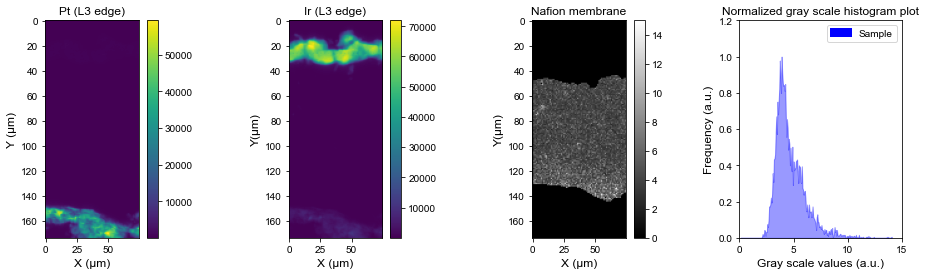

In [59]:
## Final Plots
plt.rcParams['font.family'] = rcParams

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

ax1=plt.subplot(1,4,1)
ax1.set_title('Pt (L3 edge)', fontdict=title_font)
ax1.set_xlabel('X (µm)', fontdict=label_font)
ax1.set_ylabel('Y (µm)', fontdict=label_font)
ax1.tick_params(axis='both', labelsize=label_tick)
p1=ax1.imshow(np.rot90(gray_values_pt, k=2))
fig.colorbar(p1, ax=ax1)
# Set labels with a specific font style

ax2=plt.subplot(1,4,2)
ax2.set_title('Ir (L3 edge)', fontdict=title_font)
ax2.set_xlabel("X (µm)", fontdict=label_font)
ax2.set_ylabel("Y(µm)", fontdict=label_font)
ax2.tick_params(axis='both', labelsize=label_tick)
p2=ax2.imshow(np.rot90(gray_values_ir, k=2))
fig.colorbar(p2, ax=ax2)

# Plotting the original image.
ax3=plt.subplot(1,4,3)
p3=ax3.imshow(np.rot90(images, k=2), cmap='gray')
ax3.set_title('Nafion membrane', fontdict=title_font)
ax3.set_xlabel("X (µm)", fontdict=label_font)
ax3.set_ylabel("Y(µm)", fontdict=label_font)
ax3.tick_params(axis='both', labelsize=label_tick)
# color bar parameters
color_bar = fig.colorbar(p3, ax=ax3)
custom_min_value = 0
custom_max_value = 15
p3.set_clim(vmin=custom_min_value, vmax=custom_max_value)


ax4=plt.subplot(1,4,4)
ax4.fill_between(nonzero_bins, count_values,color="blue", alpha=0.4)
ax4.set_title('Normalized gray scale histogram plot', fontdict=title_font)
ax4.set_xlabel("Gray scale values (a.u.)", fontdict=label_font)
ax4.set_ylabel("Frequency (a.u.)", fontdict=label_font)
ax4.set_xlim(0, 15) 
ax4.set_ylim(0, 1.2)
ax4.tick_params(axis='both', labelsize=label_tick)
legend_labels = ['Sample']
legend_elements = [Rectangle((0, 0), 1, 1, color='blue', edgecolor='black', lw=2)]
ax4.legend(legend_elements, legend_labels, loc='upper right',fontsize=legend_size)
#ax.plot(nonzero_bins, nonzero_values, color='red', marker='o', linestyle='-', linewidth=2) #

#ax5=plt.subplot(1,5,5)
#p5=ax5.imshow(regions, cmap='inferno')
#ax5.set_title('Nafion membrane after segmentation', fontdict=title_font)
#ax5.set_xlabel("X (µm)", fontdict=label_font)
#ax5.set_ylabel("Y(µm)", fontdict=label_font)
#ax5.tick_params(axis='both', labelsize=label_tick)
#legend_labels = ['Pt', 'Nafion']
#legend_elements = [Rectangle((0, 0), 1, 1, color='#FCFFA4', edgecolor='black', lw=2),
#                   Rectangle((0, 0), 1, 1, color='#D44842', edgecolor='black', lw=2)]
#ax5.legend(legend_elements, legend_labels, loc='upper right')

fig.subplots_adjust(wspace=0.5, hspace=0.5)
# Customize the file path
file_path = path_pic+'Main.png'

# Save only the first subplot
fig.savefig(file_path,dpi=dpi_num)
plt.show()

C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\3679163655.py:30: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



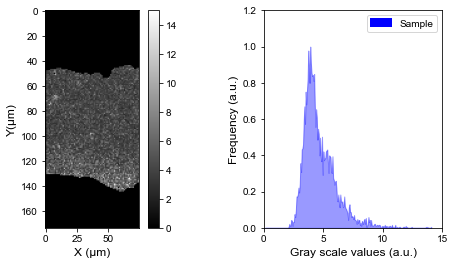

In [60]:
## Final Plots
plt.rcParams['font.family'] = rcParams

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))


# Plotting the original image.
ax3=plt.subplot(1,2,1)
p3=ax3.imshow(np.rot90(images, k=2), cmap='gray')
#ax3.set_title('Nafion membrane', fontdict=title_font)
ax3.set_xlabel("X (µm)", fontdict=label_font)
ax3.set_ylabel("Y(µm)", fontdict=label_font)
ax3.tick_params(axis='both', labelsize=label_tick)
# color bar parameters
color_bar = fig.colorbar(p3, ax=ax3)
custom_min_value = 0
custom_max_value = 15
p3.set_clim(vmin=custom_min_value, vmax=custom_max_value)


ax4=plt.subplot(1,2,2)
ax4.fill_between(nonzero_bins, count_values,color="blue", alpha=0.4)
#ax4.set_title('Normalized gray scale histogram plot', fontdict=title_font)
ax4.set_xlabel("Gray scale values (a.u.)", fontdict=label_font)
ax4.set_ylabel("Frequency (a.u.)", fontdict=label_font)
ax4.set_xlim(0, 15) 
ax4.set_ylim(0, 1.2)
ax4.tick_params(axis='both', labelsize=label_tick)
legend_labels = ['Sample']
legend_elements = [Rectangle((0, 0), 1, 1, color='blue', edgecolor='black', lw=2)]
ax4.legend(legend_elements, legend_labels, loc='upper right',fontsize=legend_size)
#ax.plot(nonzero_bins, nonzero_values, color='red', marker='o', linestyle='-', linewidth=2) #

#ax5=plt.subplot(1,5,5)
#p5=ax5.imshow(regions, cmap='inferno')
#ax5.set_title('Nafion membrane after segmentation', fontdict=title_font)
#ax5.set_xlabel("X (µm)", fontdict=label_font)
#ax5.set_ylabel("Y(µm)", fontdict=label_font)
#ax5.tick_params(axis='both', labelsize=label_tick)
#legend_labels = ['Pt', 'Nafion']
#legend_elements = [Rectangle((0, 0), 1, 1, color='#FCFFA4', edgecolor='black', lw=2),
#                   Rectangle((0, 0), 1, 1, color='#D44842', edgecolor='black', lw=2)]
#ax5.legend(legend_elements, legend_labels, loc='upper right')

fig.subplots_adjust(wspace=0.5, hspace=0.5)
# Customize the file path
file_path = path_pic+'Main2.png'

# Save only the first subplot
fig.savefig(file_path,dpi=dpi_num)
plt.show()

C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\1771090768.py:84: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\1771090768.py:85: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\1771090768.py:86: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\1771090768.py:98: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\1771090768.py:99: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



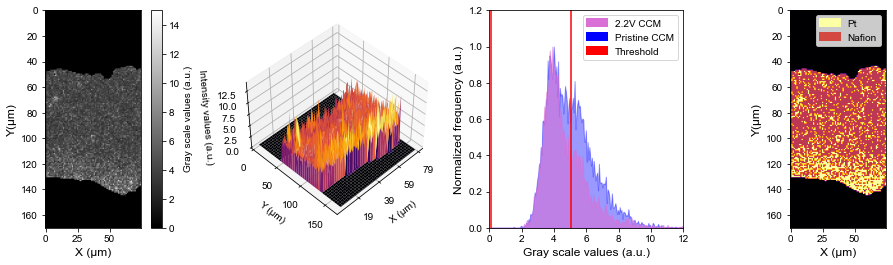

In [83]:
## load pristine histogram 
nonzero_bins_gray_pris = np.genfromtxt("D:/Data1/pshell_data/20230622/20230622113436_noXRD_XRF_XY_100ms_11700eV_008_Pristine_02_detail1_hc/processed_data/FalconX/outFast_data_scan_det"+detector+"/IMAGES/nonzero_bins_gray_"+element+"_DF.csv", delimiter=',', skip_header=1)
normalized_histogram_gray_pris = np.genfromtxt("D:/Data1/pshell_data/20230622/20230622113436_noXRD_XRF_XY_100ms_11700eV_008_Pristine_02_detail1_hc/processed_data/FalconX/outFast_data_scan_det"+detector+"/IMAGES/normalized_histogram_gray_"+element+"_DF.csv", delimiter=',', skip_header=1)


## Final Plots
plt.rcParams['font.family'] = rcParams

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(17, 4))

# Plotting the original image.----------------------------------------------------------
ax1 = ax[0]
p1=ax1.imshow(np.rot90(images, k=2), cmap='gray')
#ax1.set_title('Nafion membrane', fontdict=title_font)
ax1.set_xlabel("X (µm)", fontdict=label_font)
ax1.set_ylabel("Y(µm)", fontdict=label_font)
ax1.tick_params(axis='both', labelsize=label_tick)
ax1.set_ylim(170, 0)  # Set y-axis limits for the second subplot

# Create a color bar inside the image
color_bar = fig.colorbar(p1, ax=ax1, shrink=1, pad=0.05)
color_bar.set_label('Gray scale values (a.u.)', fontsize=10, family='Arial')
custom_min_value = 0
custom_max_value = 15
p1.set_clim(vmin=custom_min_value, vmax=custom_max_value)

# Plotting 3D ---------------------------------------------------------------
# Define the range for the Y-axis
start_y_3d = 0
end_y_3d = 170

# Crop the data to the specified range along the Y-axis
cropped_data_3d = data_3d[start_y_3d:end_y_3d, :]

# Create grid for x and y coordinates
x = np.arange(cropped_data_3d.shape[1], 0, -1) 
y = np.arange(start_y_3d, end_y_3d)  # Adjusted y-coordinates to match the cropped range
x, y = np.meshgrid(x, y)

# Create Matplotlib surface plot
ax0 =ax[1]
ax0.axis('off')
ax0 = fig.add_subplot(142, projection='3d')
surf = ax0.plot_surface(x, y, cropped_data_3d, cmap='inferno')

# Set plot title and labels
#ax0.set_title('3D plot for intensity values', fontsize=12)
ax0.set_xlabel('X (µm)', fontsize=10)
ax0.set_ylabel('Y (µm)', fontsize=10)
ax0.set_zlabel('Intensity values (a.u.)', fontsize=10)

# Set tick parameters
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)
ax0.tick_params(axis='z', labelsize=10)

tick_positions = np.arange(0, cropped_data_3d.shape[1]+4, 20)  #Set tick positions
tick_labels = np.arange(cropped_data_3d.shape[1]+4, 0, -20)  #Set tick labels in reverse order
ax0.set_xticks(tick_positions)
ax0.set_xticklabels(tick_labels)

#Y axis
start_value_3d= 0
end_value_3d= 170
# Set Y-axis range
ax0.set_ylim([start_value_3d, end_value_3d])  # Set the desired range  
# Set camera view
ax0.view_init(elev=45, azim=45)  # Adjust elevation and azimuth angles as needed
fig.patch.set_facecolor('none')
ax0.set_facecolor('none')

# Histograms--------------------------------------------------------------------------
ax2=ax[2]
ax2.fill_between(nonzero_bins_gray_pris, normalized_histogram_gray_pris,color="blue", alpha=0.4)
ax2.fill_between(nonzero_bins, count_values,color="orchid", alpha=0.6)
ax2.set_xlabel("Gray scale values (a.u.)", fontdict=label_font)
ax2.set_ylabel("Normalized frequency (a.u.)", fontdict=label_font)
ax2.tick_params(axis='both', labelsize=label_tick)
ax2.set_xlim(0, 12)
ax2.set_ylim(0, 1.2) # change according to analysis
for thresh in thresholds:
    ax2.axvline(thresh, color='r')
legend_labels = ['2.2V CCM','Pristine CCM','Threshold']
legend_elements = [Rectangle((0, 0), 1, 1, color='orchid', edgecolor='black', lw=2),
                   Rectangle((0, 0), 1, 1, color='blue', edgecolor='black', lw=2),
                   Rectangle((0, 0), 1, 1, color='red', edgecolor='black', lw=2)]
ax2.legend(legend_elements, legend_labels, loc='upper right',fontsize=legend_size)


#Segmented image--------------------------------------------------------------------------
ax3=ax[3]
p3=ax3.imshow(np.rot90(regions, k=2), cmap='inferno')
#ax3.set_title('Segmented Nafion', fontdict=title_font)
ax3.set_xlabel("X (µm)", fontdict=label_font)
ax3.set_ylabel("Y(µm)", fontdict=label_font)
ax3.tick_params(axis='both', labelsize=label_tick)
legend_labels = ['Pt', 'Nafion']
legend_elements = [Rectangle((0, 0), 1, 1, color='#FCFFA4', edgecolor='black', lw=2),
                   Rectangle((0, 0), 1, 1, color='#D44842', edgecolor='black', lw=2)]
ax3.legend(legend_elements, legend_labels, loc='upper right')
ax3.set_ylim(170, 0)  # Set y-axis limits for the second subplot


# Adjust horizontal spacing and centralize each subplot
fig.subplots_adjust(wspace=0.3)

# Customize the file path
file_path = path_pic+'Main2.png'

# Save only the first subplot
fig.savefig(file_path,dpi=dpi_num)

plt.show()

### Absorption data segmented

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


23.800716904561938


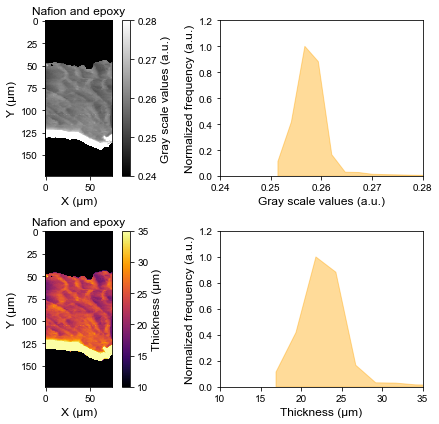

In [108]:
# load the real processed image
uri3="D:/Data1/pshell_data/"+day+"/"+sample_name+"/processed_data/FalconX/outFast_data_scan_det"+detector+"/IMAGES/mux_roi.tif"
im= io.imread(uri3)
gray_values_abs=np.rot90(im, k=2)

##------------Get only membrane absorption values------------##

gray_values_abs_DF = pd.DataFrame(gray_values_abs)
gray_values_abs_DF = gray_values_abs_DF.fillna(0)

# Find coordinates of pixels with value 0 in image1
coordinates = np.argwhere(nafion_membrane_DF1.values == 0)

# Set corresponding pixels to 0 in image2
for coord in coordinates:
    gray_values_abs_DF.iloc[coord[0], coord[1]] = 0

       
##----------------------Data treatment-----------------------##    

## Blur to data
gray_values_abs_array=gray_values_abs_DF.values
# blurry data for segmentation and generating threshold value
blurred_values_abs_array = ski.filters.gaussian(gray_values_abs_array, sigma=0.8)


# Create the matrix filled with the specified value
rows_sample, columns_sample = gray_values_abs_array.shape
air_mean_value = 0.2331723
matrix_air = np.full((rows_sample, columns_sample), air_mean_value)

##Converting gray_values of absorption contrast to Thickness 
gray_values_thickness=(gray_values_abs_array-matrix_air)*926 # X-Ray attenuation lenght for Nafion
gray_values_thickness_DF=pd.DataFrame(gray_values_thickness) 
binary_mask_values_thickness_DF = gray_values_thickness_DF > 0
gray_values_thickness_DF[~binary_mask_values_thickness_DF] = 0       

##-----------------------Histograms-------------------------##

##Histogram for abs signal
filtered_data_abs = gray_values_abs_DF.values[gray_values_abs_DF.values != 0]
histogram_abs, bin_edges_abs = np.histogram(filtered_data_abs,bins=256)
# Find the maximum count in the histogram
max_count_abs = np.max(histogram_abs)
# Normalize the histogram data
normalized_histogram_abs = histogram_abs/max_count_abs

##Histogram for thickness
filtered_data_thickness = gray_values_thickness_DF.values[gray_values_thickness_DF.values != 0]
histogram, bin_edges = np.histogram(filtered_data_thickness,bins=256)

# Find the maximum count in the histogram
max_count = np.max(histogram)
# Normalize the histogram data
normalized_histogram = histogram/max_count

filtered_values = gray_values_thickness_DF.values.flatten()
filtered_values = filtered_values[(filtered_values > 0) & (filtered_values <= 35)]
mean_values = filtered_values.mean()
print(mean_values)
    
##--------------------------Plots--------------------------##        
    
plt.rcParams['font.family'] = rcParams

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 6))

###### Gray scale values
ax1=plt.subplot(2,2,1)
p1=ax1.imshow(np.rot90(gray_values_abs_DF, k=2), cmap='gray')
ax1.set_title('Nafion and epoxy', fontdict=title_font)
ax1.set_xlabel('X (µm)', fontdict=label_font)
ax1.set_ylabel('Y (µm)', fontdict=label_font)
color_bar = fig.colorbar(p1, ax=ax1, shrink=1, pad=0.05)
color_bar.set_label('Gray scale values (a.u.)', fontdict=label_font)
color_bar.set_label('Gray scale values (a.u.)', fontdict=label_font)
custom_min_value = 0.24
custom_max_value = 0.280
p1.set_clim(vmin=custom_min_value, vmax=custom_max_value)

###### Histogram
ax2=plt.subplot(2,2,2)
ax2.fill_between(bin_edges_abs[0:-1], normalized_histogram_abs,color="orange", alpha=0.4)
ax2.set_xlabel("Gray scale values (a.u.)", fontdict=label_font)
ax2.set_ylabel("Normalized frequency (a.u.)", fontdict=label_font)
ax2.set_xlim(0.24, 0.28)
ax2.set_ylim(0, 1.2) # change according to analysis

###### Quantities
ax3=plt.subplot(2,2,3)
p3=ax3.imshow(np.rot90(gray_values_thickness_DF, k=2), cmap='inferno')
ax3.set_title('Nafion and epoxy', fontdict=title_font)
ax3.set_xlabel('X (µm)', fontdict=label_font)
ax3.set_ylabel('Y (µm)', fontdict=label_font)
color_bar = fig.colorbar(p3, ax=ax3, shrink=1, pad=0.05)
color_bar.set_label('Thickness (μm)', fontdict=label_font)
custom_min_value_quanti = 10
custom_max_value_quanti = 35
p3.set_clim(vmin=custom_min_value_quanti, vmax=custom_max_value_quanti)

###### Histogram
ax4=plt.subplot(2,2,4)
ax4.fill_between(bin_edges[0:-1], normalized_histogram,color="orange", alpha=0.4)
ax4.set_xlabel("Thickness (μm)", fontdict=label_font)
ax4.set_ylabel("Normalized frequency (a.u.)", fontdict=label_font)
ax4.set_xlim(10, 35)
ax4.set_ylim(0, 1.2) # change according to analysis


plt.tight_layout()
plt.show()

### Quantification

C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\2774885728.py:57: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\2774885728.py:58: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



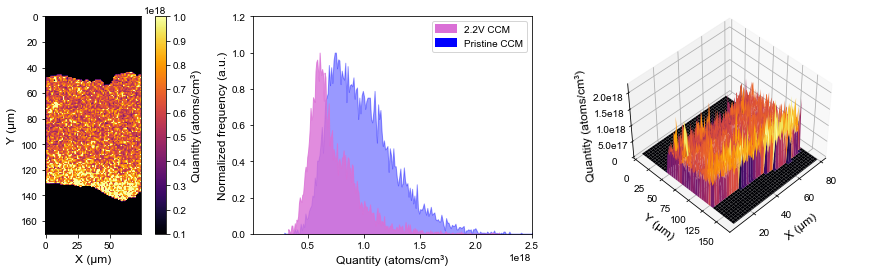

In [111]:
# Create the matrix filled with the average value for thickness (there is too much Pt inside the edge of the membrane)
######## NOTICE THIS IS JUST AN ESTIMATION!!!!! AND NOT LOCAL THICKNESS ANYMORE!!!!#########
gray_values_thickness_array=gray_values_thickness_DF.values
rows_thick, columns_thick = gray_values_thickness_array.shape
air_mean_value = mean_values
matrix_thick = np.full((rows_thick, columns_thick), air_mean_value)
matrix_thick_DF=pd.DataFrame(matrix_thick)

#Quanti
images_DF=pd.DataFrame(images)
quanti_DF = images_DF*3.75E14/(matrix_thick_DF*1E-4) ## 3.75E14 comes from Conversion Factor (atoms/cm2) / counts -- 11.7 KeV detector 02 for Pt
quanti_DF=quanti_DF.replace([np.inf, -np.inf], np.nan) ## weird numbers appearing (due to number/0 tends to inf)
quanti_DF.fillna(0, inplace=True) ## removes 0's
quanti=quanti_DF.values ## change to numpy array 


## load pristine sample data for histogram

bin_edges_quanti_pris = np.genfromtxt("D:/Data1/pshell_data/20230622/20230622113436_noXRD_XRF_XY_100ms_11700eV_008_Pristine_02_detail1_hc/processed_data/FalconX/outFast_data_scan_det"+detector+"/IMAGES/bin_edges_quanti_"+element+"_DF.csv", delimiter=',', skip_header=1)
normalized_histogram_quanti_pris = np.genfromtxt("D:/Data1/pshell_data/20230622/20230622113436_noXRD_XRF_XY_100ms_11700eV_008_Pristine_02_detail1_hc/processed_data/FalconX/outFast_data_scan_det"+detector+"/IMAGES/normalized_histogram_quanti_"+element+"_DF.csv", delimiter=',', skip_header=1)


##histogram for quatities
filtered_data_quanti = quanti[quanti != 0]
histogram_quanti, bin_edges_quanti = np.histogram(filtered_data_quanti,bins=256)
# Find the maximum count in the histogram
max_count_quanti = np.max(histogram_quanti)
# Normalize the histogram data
normalized_histogram_quanti = histogram_quanti/max_count_quanti


##--------------------------Plots--------------------------##   
plt.rcParams['font.family'] = rcParams

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17, 4))

ax1= plt.subplot(1,3,1)
p1=ax1.imshow(np.rot90(quanti_DF, k=2), cmap='inferno')
ax1.set_xlabel('X (µm)', fontdict=label_font)
ax1.set_ylabel('Y (µm)', fontdict=label_font)
ax1.set_ylim(170, 0)  # Set y-axis limits for the second subplot
color_bar = fig.colorbar(p1, ax=ax1, shrink=1, pad=0.05)
color_bar.set_label('Quantity (atoms/cm³)', fontdict=label_font)
custom_min_value = 0.1E18
custom_max_value = 1E18
p1.set_clim(vmin=custom_min_value, vmax=custom_max_value)

###### Histogram
ax2= plt.subplot(1,3,2)
ax2.fill_between(bin_edges_quanti_pris[0:-1], normalized_histogram_quanti_pris,color="blue", alpha=0.4)
ax2.fill_between(bin_edges_quanti[0:-1], normalized_histogram_quanti,color="orchid", alpha=0.8)
ax2.set_xlabel("Quantity (atoms/cm³)", fontdict=label_font)
ax2.set_ylabel("Normalized frequency (a.u.)", fontdict=label_font)
ax2.set_xlim(0.01e18, 2.5e18)
ax2.set_ylim(0, 1.2) # change according to analysis
legend_labels = ['2.2V CCM','Pristine CCM']
legend_elements = [Rectangle((0, 0), 1, 1, color='orchid', edgecolor='black', lw=2),
                   Rectangle((0, 0), 1, 1, color='blue', edgecolor='black', lw=2)]
ax2.legend(legend_elements, legend_labels, loc='upper right',fontsize=legend_size)
fig.patch.set_facecolor('none')
ax2.set_facecolor('none')

# Plotting 3D ---------------------------------------------------------------
# Assuming nafion_membrane_DF3D.values is your matrix data
data_3d_thick = np.rot90(quanti, k=2)
# Define the range for the Y-axis
start_y_3d_thick = 0
end_y_3d_thick = 170

# Crop the data to the specified range along the Y-axis
cropped_data_3d_thick = data_3d_thick[start_y_3d_thick:end_y_3d_thick, :]

# Create grid for x and y coordinates
x_thick = np.arange(cropped_data_3d_thick.shape[1], 0, -1) 
y_thick = np.arange(start_y_3d_thick, end_y_3d_thick)  # Adjusted y-coordinates to match the cropped range
x_thick, y_thick = np.meshgrid(x_thick, y_thick)

# Create Matplotlib surface plot
ax3= plt.subplot(1,3,3)
ax3.axis('off')
ax3 = fig.add_subplot(133, projection='3d')
surf_thick = ax3.plot_surface(x_thick, y_thick, cropped_data_3d_thick, cmap='inferno')

# Set plot title and labels
#ax0.set_title('3D plot for intensity values', fontsize=12)
ax3.set_xlabel('X (µm)', fontdict=label_font)
ax3.set_ylabel('Y (µm)', fontdict=label_font)
ax3.set_zlabel('', fontdict=label_font,labelpad=-1)


# Custom formatter to remove the + sign from scientific notation
def scientific_formatter(x, pos):
    if x == 0:
        return '0'
    # Convert to scientific notation with no + sign for the exponent
    return f'{x:.1e}'.replace('e+0', 'e0').replace('e+0', 'e0').replace('e+', 'e').replace('e-0', 'e-')
# Apply custom formatter to the z-axis
ax3.zaxis.set_major_formatter(FuncFormatter(scientific_formatter))


# Custom annotation for z-axis label
ax3.text2D(-0.2, 0.25, 'Quantity (atoms/cm³)', fontdict=label_font, rotation=96, transform=ax3.transAxes)


# Set tick parameters
ax3.tick_params(axis='x', labelsize=10)
ax3.tick_params(axis='y', labelsize=10)
ax3.tick_params(axis='z', labelsize=10)

tick_positions_thick = np.arange(0, cropped_data_3d_thick.shape[1]+5, 20)  #Set tick positions
tick_labels_thick = np.arange(cropped_data_3d_thick.shape[1]+5, 0, -20)  #Set tick labels in reverse order
ax3.set_xticks(tick_positions_thick)
ax3.set_xticklabels(tick_labels_thick)

#Y axis
start_value_3d_thick= 0
end_value_3d_thick= 170
# Set Y-axis range
ax3.set_ylim([start_value_3d_thick, end_value_3d_thick])  # Set the desired range  
# Set camera view
ax3.view_init(elev=45, azim=45)  # Adjust elevation and azimuth angles as needed
#remove white background 
fig.patch.set_facecolor('none')
ax3.set_facecolor('none')

# Customize the file path
file_path = path_pic+'Quanti.png'
# Save only the first subplot
fig.savefig(file_path,dpi=dpi_num)

plt.show()


C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\6314266.py:26: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

C:\Users\ra5994\AppData\Local\Temp\ipykernel_44200\6314266.py:27: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



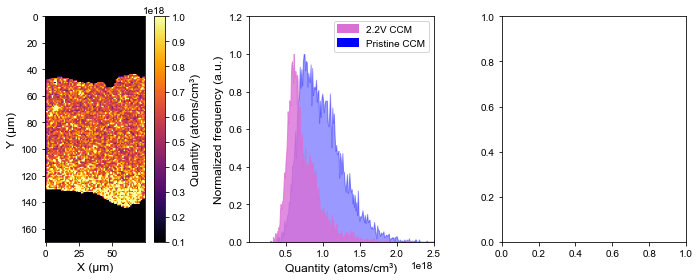

D:/Data1/pshell_data/20230624/20230624020313_noXRD_XRF_XY_100ms_11700eV_017_2.2V_II_20_01_detail_hc/processed_data/FalconX/Final_Plots_paper_Pt/Quanti2.png


In [113]:
##--------------------------Plots XRM--------------------------##   
plt.rcParams['font.family'] = rcParams

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

ax1= plt.subplot(1,3,1)
p1=ax1.imshow(np.rot90(quanti_DF, k=2), cmap='inferno')
ax1.set_xlabel('X (µm)', fontdict=label_font)
ax1.set_ylabel('Y (µm)', fontdict=label_font)
ax1.set_ylim(170, 0)  # Set y-axis limits for the second subplot
color_bar = fig.colorbar(p1, ax=ax1, shrink=1, pad=0.05)
color_bar.set_label('Quantity (atoms/cm³)', fontdict=label_font)
custom_min_value = 0.1E18
custom_max_value = 1E18
p1.set_clim(vmin=custom_min_value, vmax=custom_max_value)

###### Histogram
ax2= plt.subplot(1,3,2)
ax2.fill_between(bin_edges_quanti_pris[0:-1], normalized_histogram_quanti_pris,color="blue", alpha=0.4)
ax2.fill_between(bin_edges_quanti[0:-1], normalized_histogram_quanti,color="orchid", alpha=0.8)
ax2.set_xlabel("Quantity (atoms/cm³)", fontdict=label_font)
ax2.set_ylabel("Normalized frequency (a.u.)", fontdict=label_font)
ax2.set_xlim(0.01e18, 2.5e18)
ax2.set_ylim(0, 1.2) # change according to analysis
legend_labels = ['2.2V CCM','Pristine CCM']
legend_elements = [Rectangle((0, 0), 1, 1, color='orchid', edgecolor='black', lw=2),
                   Rectangle((0, 0), 1, 1, color='blue', edgecolor='black', lw=2)]
ax2.legend(legend_elements, legend_labels, loc='upper right',fontsize=legend_size)
fig.patch.set_facecolor('none')
ax2.set_facecolor('none')

plt.tight_layout()

# Customize the file path
file_path = path_pic+'Quanti2.png'
# Save only the first subplot
fig.savefig(file_path,dpi=dpi_num)

plt.show()


print(file_path)

In [114]:
import scipy.ndimage

# Original data
quanti_DF3D=quanti_DF

# Apply a Gaussian filter to smooth the data
sigma = 1  # Standard deviation for Gaussian kernel. Adjust this to control the amount of smoothing.
smoothed_data = scipy.ndimage.gaussian_filter(quanti_DF3D, sigma=sigma)

# Create the surface plot with the smoothed data
fig_quanti = go.Figure(data=[go.Surface(z=np.rot90(smoothed_data, k=2), showscale=False)])
fig_quanti.update_layout(
    autosize=False,
    width=500, height=500,
    scene=dict(
         xaxis=dict(title='X', titlefont=dict(size=10, family='Arial'), tickfont=dict(size=10, family='Arial'), tickmode='auto', tick0=-5, autorange='reversed'),
        yaxis=dict(title='Y', titlefont=dict(size=10, family='Arial'), tickfont=dict(size=10, family='Arial'), tickmode='auto', tick0=-5),
        zaxis=dict(title='Quantity (atoms/cm³)', titlefont=dict(size=10, family='Arial'), tickfont=dict(size=10, family='Arial'), tickmode='auto', tick0=-2),
        camera=dict(
            eye=dict(x=1.75, y=1.75, z=1.75)  # Set the initial zoom size
        )
    )
    
)

fig_quanti.show()

# Create the surface plot with your data
fig_quanti.update_layout(
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=0),  # Remove margins
    scene=dict(
        xaxis=dict(
            title='X',
            autorange="reversed",  # Reverse the X-axis
        ),
        yaxis=dict(
            title='Y',
            autorange=True,
        ),
        zaxis=dict(
            title='Quantity (atoms/cm³)',
            autorange=True,
        ),
        bgcolor='white'  # Set background color of the plot area
    ),
    plot_bgcolor='white',  # Set background color of the entire plot area
)

# Define the folder and file path
folder_path = "path_html"  # Replace with your folder path
os.makedirs(folder_path, exist_ok=True)  # Create the folder if it does not exist
html_file_name = "surface_plot_100h_"+element+".html"
html_file_path = os.path.join(folder_path, html_file_name)

# Save the figure as an HTML file
fig_quanti.write_html(html_file_path, config=dict(displayModeBar=False))


# Modify the HTML to center the plot and ensure the white background
css_style = """
<style>
    body {
        margin: 0;
        padding: 0;
        display: flex;
        justify-content: center;
        align-items: center;
        height: 100vh;
        background-color: #f0f0f0;
    }
    #plotly-graph {
        width: 100%;
        height: 100%;
        max-width: 1000px; /* Set a maximum width */
        max-height: 800px; /* Set a maximum height */
    }
</style>
"""

# Read and modify the HTML file
with open(html_file_path, 'r') as file:
    html_content = file.read()

# Insert CSS into HTML content
html_content = html_content.replace('</head>', f'{css_style}</head>')

# Write the modified HTML back to the file
with open(html_file_path, 'w') as file:
    file.write(html_content)

# Print the path of the saved HTML file
print(os.getcwd())


# Replace this link with the GitHub Pages URL
link = "https://Leonardolac97.github.io/XRF-3D-Maps/surface_plot_100h_"+element+".html"

# Generate the QR code
qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)
qr.add_data(link)
qr.make(fit=True)

# Create an image of the QR code
img = qr.make_image(fill='black', back_color="white")

# Save the image
qr_dir="C:/Users/ra5994/PEM samples/Paper 2/"+element+"/path_qr"
if os.path.exists(qr_dir):
    shutil.rmtree(qr_dir)
    os.mkdir(qr_dir) 
else:
    os.mkdir(qr_dir) 

img.save(qr_dir+"/surface_plot_100h_"+element+"_qr.png")

# Display the QR code
img.show()


print(link)

C:\Users\ra5994\PEM samples\Paper 2\Pt
https://Leonardolac97.github.io/XRF-3D-Maps/surface_plot_100h_Pt.html
